In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(11, 4)})

## Load data

In [234]:
samples = pd.read_csv("data/raw/dataset_mood_smartphone.csv", 
                      sep=',', 
                      index_col=0, 
                      parse_dates=["time"],
                      dtype={"id": "category", "variable": "category"})
samples = samples.rename(columns={"time": "datetime"})
samples

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove duplicates

In [235]:
dupes = samples.duplicated(subset=['datetime', 'variable', 'id'], keep='last')
samples_deduped = samples[dupes == False]

## Remove negative values for appCat.* variables

In [236]:
samples_cleaned = samples_deduped[(~(samples_deduped['variable'].str.startswith('app'))) |
                                   ((samples_deduped['variable'].str.startswith('app')) & 
                                   (samples_deduped['value'] > 0))]
samples_cleaned

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove outliers

In [237]:
## Todo

## Pivot the data to a time indexed data frame 
https://pandas.pydata.org/docs/user_guide/reshaping.html

In [238]:
vdata = samples_cleaned.pivot(index="datetime", columns=["id", "variable"], values="value")
vdata

id,AS14.01,AS14.02,AS14.03,AS14.05,AS14.06,AS14.07,AS14.08,AS14.09,AS14.12,AS14.13,...,AS14.06,AS14.09,AS14.12,AS14.16,AS14.25,AS14.26,AS14.27,AS14.28,AS14.30,AS14.32
variable,mood,mood,mood,mood,mood,mood,mood,mood,mood,mood,...,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather
datetime,,,,,,,,,,,,,,,,,,,,,
2014-02-17 07:00:52.197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:12:13.631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:49:19.635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:57:16.313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:58:58.471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-08 11:03:34.453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-08 11:04:20.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Make features
More feature ideas: 
- weekday vs. weekend day
- day of the week
- recent values from patient-reported data
- relevant app usage data
- use weighted window for aggregated features from the past days

To do feature engineering:
- remove timespans with no mood data: keep only the longest continuous timespan with mood data

To do data cleaning:
- discard outliers

In [239]:
ids = list(samples["id"].unique())
d = {}
for id in ids:
    d[(id, "mood_1D")] = vdata.loc[:, (id , 'mood')].resample('D').mean()
    d[(id, "valence_1D")] = vdata.loc[:, (id , 'circumplex.valence')].resample('D').mean()
    d[(id, "arousal_1D")] = vdata.loc[:, (id , 'circumplex.arousal')].resample('D').mean()
    d[(id, "social_1D")] = vdata.loc[:, (id , 'appCat.social')].resample('D').sum()
    d[(id, "social_rolling_5D")] = vdata.loc[:, (id , 'appCat.social')].rolling('5D').sum().resample('D').mean() / 5
    d[(id, "social_rolling_10D")] = vdata.loc[:, (id , 'appCat.social')].rolling('10D').sum().resample('D').mean() / 10
    
    mood = vdata.loc[:, (id, 'mood')]
    mood.dropna(inplace=True)
    d[(id, 'mood_first')] = mood.resample('D').first()
    d[(id, 'mood_last')] = mood.resample('D').last()
    d[(id, 'mood_delta')] = features.loc[:, (id, 'mood_last')] - features.loc[:, (id, 'mood_first')]
    
    d[(id, "target")] = vdata.loc[:, (id , 'mood')].resample('D').mean().shift(-1)
    d[(id, "target_binary")] = (d[(id, "target")] >= 7).astype(int)
    
features = pd.DataFrame(d)
features

AS14.01                                                    \
           mood_1D valence_1D arousal_1D social_1D social_rolling_5D   
datetime                                                               
2014-02-17     NaN        NaN        NaN       0.0               NaN   
2014-02-18     NaN        NaN        NaN       0.0               NaN   
2014-02-19     NaN        NaN        NaN       0.0               NaN   
2014-02-20     NaN        NaN        NaN       0.0               NaN   
2014-02-21     NaN        NaN        NaN       0.0               NaN   
...            ...        ...        ...       ...               ...   
2014-06-05     NaN        NaN        NaN       0.0               NaN   
2014-06-06     NaN        NaN        NaN       0.0               NaN   
2014-06-07     NaN        NaN        NaN       0.0               NaN   
2014-06-08     NaN        NaN        NaN       0.0               NaN   
2014-06-09     NaN        NaN        NaN       0.0               NaN   

                                                                      ...  \
           social_rolling_10D mood_first mood_last mood_delta target  ...   
datetime                                                              ...   
2014-02-17                NaN        NaN       NaN        NaN    NaN  ...   
2014-02-18                NaN        NaN       NaN        NaN    NaN  ...   
2014-02-19                NaN        NaN       NaN        NaN    NaN  ...   
2014-02-20                NaN        NaN       NaN        NaN    NaN  ...   
2014-02-21                NaN        NaN       NaN        NaN    NaN  ...   
...                       ...        ...       ...        ...    ...  ...   
2014-06-05                NaN        NaN       NaN        NaN    NaN  ...   
2014-06-06                NaN        NaN       NaN        NaN    NaN  ...   
2014-06-07                NaN        NaN       NaN        NaN    NaN  ...   
2014-06-08                NaN        NaN       NaN        NaN    NaN  ...   
2014-06-09                NaN        NaN       NaN        NaN    NaN  ...   

              AS14.33                                         \
           valence_1D arousal_1D social_1D social_rolling_5D   
datetime                                                       
2014-02-17        NaN        NaN       0.0               NaN   
2014-02-18        NaN        NaN       0.0               NaN   
2014-02-19        NaN        NaN       0.0               NaN   
2014-02-20        NaN        NaN       0.0               NaN   
2014-02-21        NaN        NaN       0.0               NaN   
...               ...        ...       ...               ...   
2014-06-05        NaN        NaN       0.0               NaN   
2014-06-06        NaN        NaN       0.0               NaN   
2014-06-07        NaN        NaN       0.0               NaN   
2014-06-08        NaN        NaN       0.0               NaN   
2014-06-09        NaN        NaN       0.0               NaN   

                                                                      \
           social_rolling_10D mood_first mood_last mood_delta target   
datetime                                                               
2014-02-17                NaN        NaN       NaN        NaN    NaN   
2014-02-18                NaN        NaN       NaN        NaN    NaN   
2014-02-19                NaN        NaN       NaN        NaN    NaN   
2014-02-20                NaN        NaN       NaN        NaN    NaN   
2014-02-21                NaN        NaN       NaN        NaN    NaN   
...                       ...        ...       ...        ...    ...   
2014-06-05        1497.527814        NaN       NaN        NaN    NaN   
2014-06-06        1135.224557        NaN       NaN        NaN    NaN   
2014-06-07         885.347048        NaN       NaN        NaN    NaN   
2014-06-08         425.951245        NaN       NaN        NaN    NaN   
2014-06-09         316.640900        NaN       NaN        NaN    NaN   

                 

In [240]:
features.index

DatetimeIndex(['2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26',
               ...
               '2014-05-31', '2014-06-01', '2014-06-02', '2014-06-03',
               '2014-06-04', '2014-06-05', '2014-06-06', '2014-06-07',
               '2014-06-08', '2014-06-09'],
              dtype='datetime64[ns]', name='datetime', length=113, freq='D')

In [241]:
features.columns.tolist()

[('AS14.01', 'mood_1D'),
 ('AS14.01', 'valence_1D'),
 ('AS14.01', 'arousal_1D'),
 ('AS14.01', 'social_1D'),
 ('AS14.01', 'social_rolling_5D'),
 ('AS14.01', 'social_rolling_10D'),
 ('AS14.01', 'mood_first'),
 ('AS14.01', 'mood_last'),
 ('AS14.01', 'mood_delta'),
 ('AS14.01', 'target'),
 ('AS14.01', 'target_binary'),
 ('AS14.02', 'mood_1D'),
 ('AS14.02', 'valence_1D'),
 ('AS14.02', 'arousal_1D'),
 ('AS14.02', 'social_1D'),
 ('AS14.02', 'social_rolling_5D'),
 ('AS14.02', 'social_rolling_10D'),
 ('AS14.02', 'mood_first'),
 ('AS14.02', 'mood_last'),
 ('AS14.02', 'mood_delta'),
 ('AS14.02', 'target'),
 ('AS14.02', 'target_binary'),
 ('AS14.03', 'mood_1D'),
 ('AS14.03', 'valence_1D'),
 ('AS14.03', 'arousal_1D'),
 ('AS14.03', 'social_1D'),
 ('AS14.03', 'social_rolling_5D'),
 ('AS14.03', 'social_rolling_10D'),
 ('AS14.03', 'mood_first'),
 ('AS14.03', 'mood_last'),
 ('AS14.03', 'mood_delta'),
 ('AS14.03', 'target'),
 ('AS14.03', 'target_binary'),
 ('AS14.05', 'mood_1D'),
 ('AS14.05', 'valence_1D

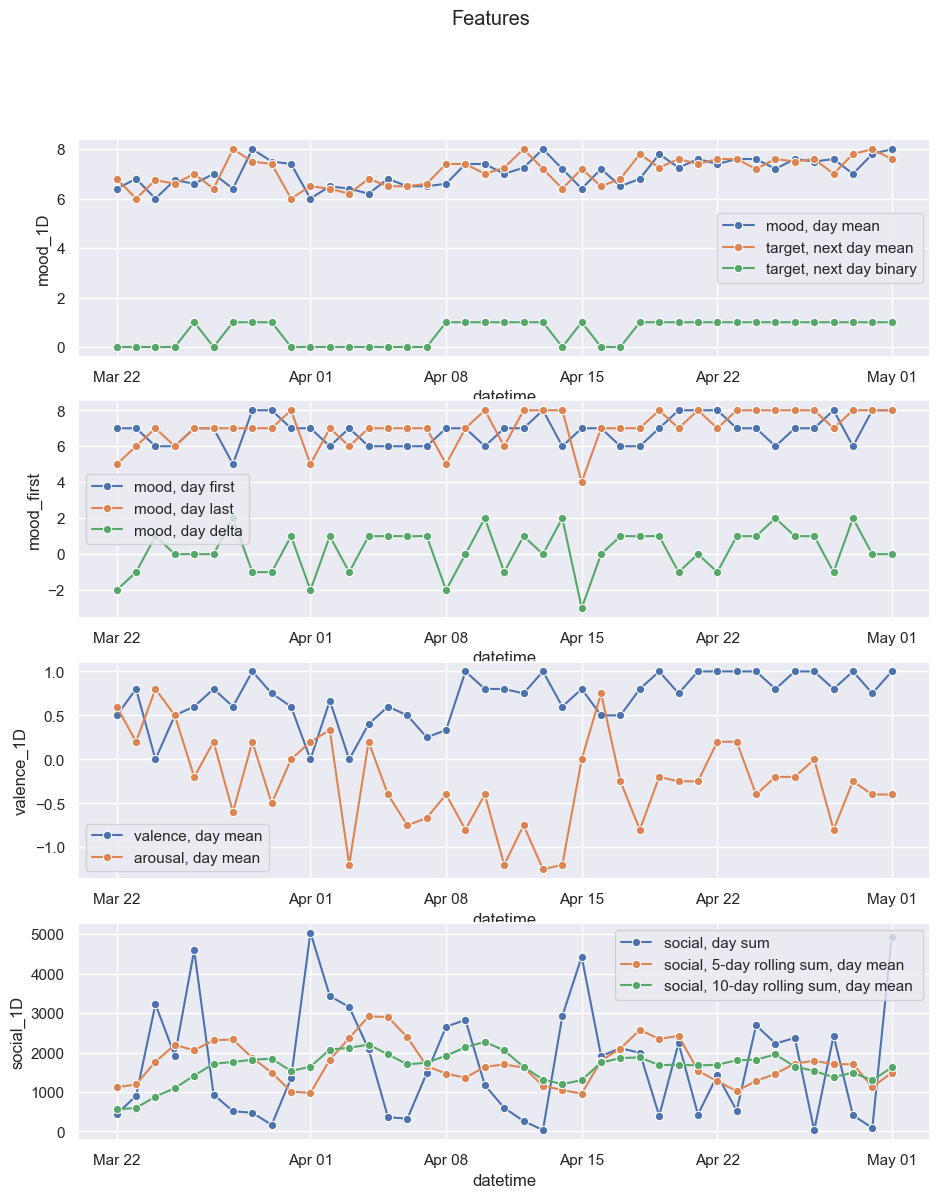

In [243]:
id = 'AS14.01'
start, end = '2014-03-22', '2014-05-01'
data = features[id]

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(11, 13))
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.suptitle('Features')

sns.lineplot(ax=axs[0], data=data['mood_1D'].loc[start:end], label='mood, day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target'].loc[start:end], label='target, next day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target_binary'].loc[start:end], label='target, next day binary', marker='o')

sns.lineplot(ax=axs[1], data=data['mood_first'].loc[start:end], label='mood, day first', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_last'].loc[start:end], label='mood, day last', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_delta'].loc[start:end], label='mood, day delta', marker='o')

sns.lineplot(ax=axs[2], data=data['valence_1D'].loc[start:end], label='valence, day mean', marker='o')
sns.lineplot(ax=axs[2], data=data['arousal_1D'].loc[start:end], label='arousal, day mean', marker='o')

sns.lineplot(ax=axs[3], data=data['social_1D'].loc[start:end], marker='o', label='social, day sum')
sns.lineplot(ax=axs[3], data=data['social_rolling_5D'].loc[start:end], marker='o', label='social, 5-day rolling sum, day mean ');
sns.lineplot(ax=axs[3], data=data['social_rolling_10D'].loc[start:end], marker='o', label='social, 10-day rolling sum, day mean ');


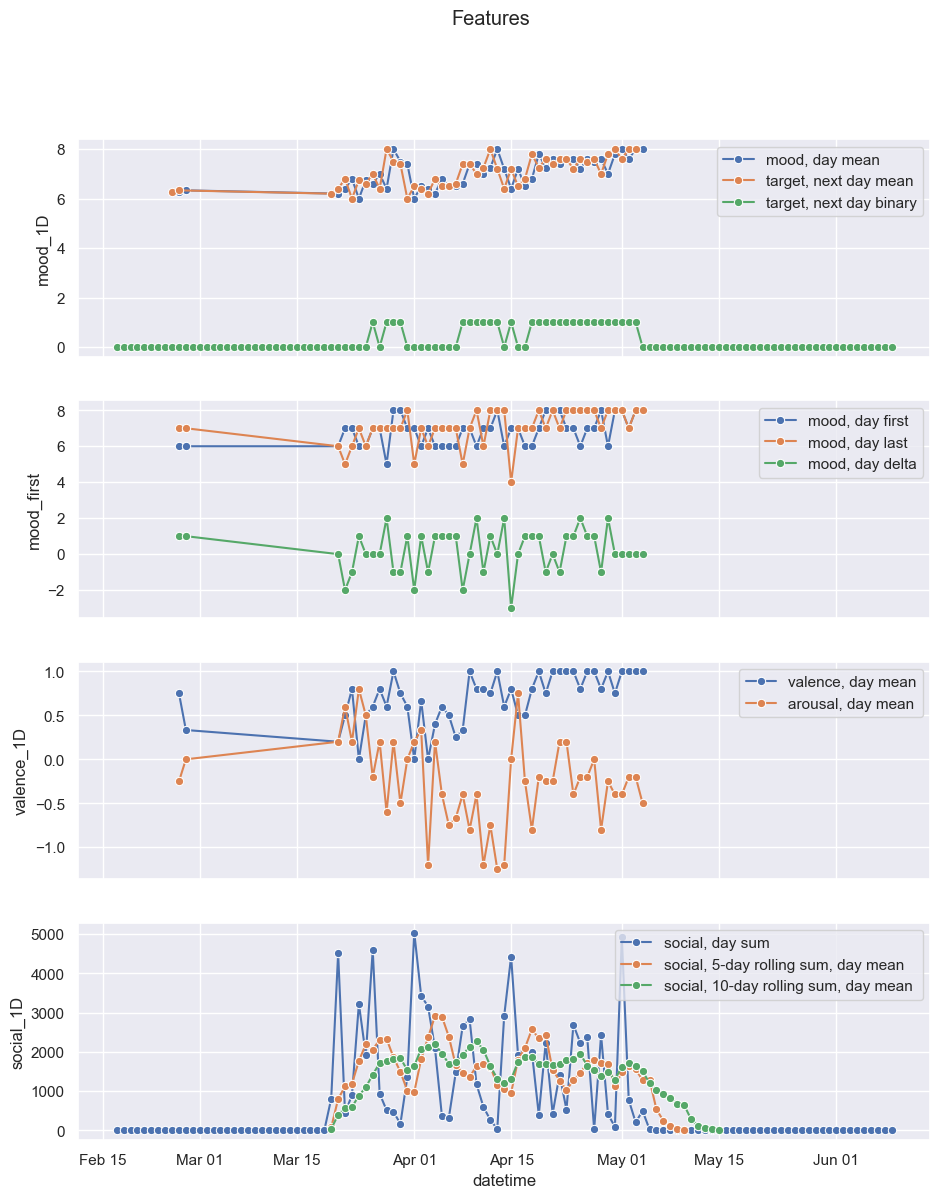

In [271]:
id = 'AS14.01'
data = features[id]

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(11, 13))
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.suptitle('Features')

sns.lineplot(ax=axs[0], data=data['mood_1D'], label='mood, day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target'], label='target, next day mean', marker='o')
sns.lineplot(ax=axs[0], data=data['target_binary'], label='target, next day binary', marker='o')

sns.lineplot(ax=axs[1], data=data['mood_first'], label='mood, day first', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_last'], label='mood, day last', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_delta'], label='mood, day delta', marker='o')

sns.lineplot(ax=axs[2], data=data['valence_1D'], label='valence, day mean', marker='o')
sns.lineplot(ax=axs[2], data=data['arousal_1D'], label='arousal, day mean', marker='o')

sns.lineplot(ax=axs[3], data=data['social_1D'], marker='o', label='social, day sum')
sns.lineplot(ax=axs[3], data=data['social_rolling_5D'], marker='o', label='social, 5-day rolling sum, day mean ');
sns.lineplot(ax=axs[3], data=data['social_rolling_10D'], marker='o', label='social, 10-day rolling sum, day mean ');


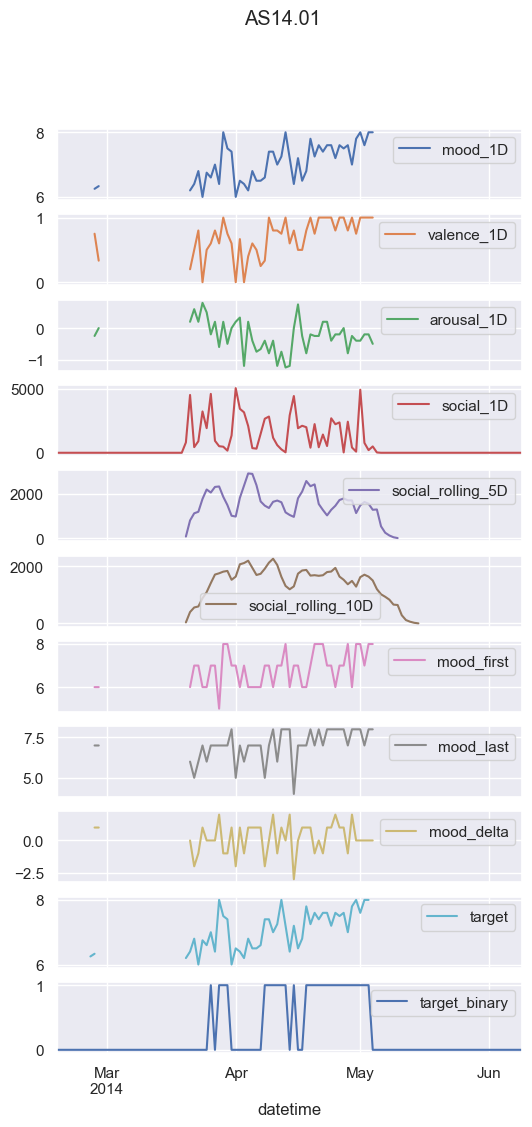

In [244]:
data.plot(subplots=True, figsize=(6, 12), title=id);

## Train and evaluate

### Toy: decision trees for patient AS14.01

In [254]:
id = 'AS14.01'

In [287]:
x = features[id][['mood_1D', 'valence_1D']].dropna()[2:]
x

,mood_1D,valence_1D
datetime,,
2014-03-21,6.20,0.200000
2014-03-22,6.40,0.500000
2014-03-23,6.80,0.800000
2014-03-24,6.00,0.000000
2014-03-25,6.75,0.500000
2014-03-26,6.60,0.600000
2014-03-27,7.00,0.800000
2014-03-28,6.40,0.600000
2014-03-29,8.00,1.000000


In [273]:
len(x)

47

In [274]:
y = features[id]['target_binary']

In [378]:
len(x), len(y), type(x), type(y)

(45, 45, pandas.core.frame.DataFrame, numpy.ndarray)

In [276]:
x.index

DatetimeIndex(['2014-02-26', '2014-02-27', '2014-03-21', '2014-03-22',
               '2014-03-23', '2014-03-24', '2014-03-25', '2014-03-26',
               '2014-03-27', '2014-03-28', '2014-03-29', '2014-03-30',
               '2014-03-31', '2014-04-01', '2014-04-02', '2014-04-03',
               '2014-04-04', '2014-04-05', '2014-04-06', '2014-04-07',
               '2014-04-08', '2014-04-09', '2014-04-10', '2014-04-11',
               '2014-04-12', '2014-04-13', '2014-04-14', '2014-04-15',
               '2014-04-16', '2014-04-17', '2014-04-18', '2014-04-19',
               '2014-04-20', '2014-04-21', '2014-04-22', '2014-04-23',
               '2014-04-24', '2014-04-25', '2014-04-26', '2014-04-27',
               '2014-04-28', '2014-04-29', '2014-04-30', '2014-05-01',
               '2014-05-02', '2014-05-03', '2014-05-04'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [288]:
y = y.reindex_like(x)

In [289]:
len(x), len(y)

(45, 45)

<Axes: xlabel='datetime', ylabel='target_binary'>

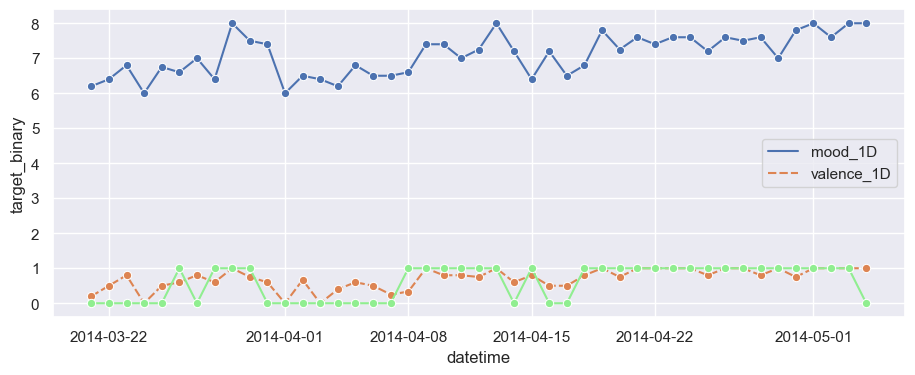

In [290]:
sns.lineplot(x, marker='o')
sns.lineplot(y, marker='o', color='lightgreen')

In [292]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [293]:
y

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0])

In [345]:
"""Decision tree"""
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier()
scores = cross_val_score(clf, x, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.55555556 0.88888889 0.55555556 1.         0.77777778]
0.76 accuracy with a standard deviation of 0.18


In [364]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = x.iloc[:36], x.iloc[36:], y[:36], y[36:]
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
clf.fit(x_train, y_train)

y_train_predicted = clf.predict(x_train)
accuracy_train = accuracy_score(y_train, y_train_predicted)

y_test_predicted = clf.predict(x_test)
accuracy_test = accuracy_score(y_test, y_test_predicted)


print(f"accuracy_train = {accuracy_train:0.2f}")
print(f"accuracy_test  = {accuracy_test:0.2f}")

(36, 2) (9, 2) (36,) (9,)
accuracy_train = 0.94
accuracy_test  = 0.78


In [375]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statistics import mean, stdev

accuracy = { 'train': [], 'test': [] }
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    clf.fit(x_train, y_train)

    y_train_predicted = clf.predict(x_train)
    accuracy['train'].append(accuracy_score(y_train, y_train_predicted))

    y_test_predicted = clf.predict(x_test)
    accuracy['test'].append(accuracy_score(y_test, y_test_predicted))


# print(f"accuracy train = {accuracy['train']}")
# print(f"accuracy test  = {accuracy['test']}")

print(f"{mean(accuracy['train']):0.2f} accuracy with a standard deviation of {stdev(accuracy['train']):0.2f}") 
print(f"{mean(accuracy['test']):0.2f} accuracy with a standard deviation of {stdev(accuracy['test']):0.2f}" )


0.95 accuracy with a standard deviation of 0.02
0.80 accuracy with a standard deviation of 0.10
